In [1]:
!rm -rf densenet_onnx/dataset
!mkdir densenet_onnx/dataset
!cd densenet_onnx/dataset; touch .gitkeep; cd -

/home/jovyan/work/edge-benchmarking-client/examples


In [2]:
import shutil
from pathlib import Path

base_dataset_paths = [
    Path("densenet_onnx/base_dataset/car.jpg"),
    Path("densenet_onnx/base_dataset/mug.jpg"),
    Path("densenet_onnx/base_dataset/vulture.jpeg")
]

for i in range(100):
    for base_image_path in base_dataset_paths:
        dst_image_path = Path("densenet_onnx/dataset", f"{i}_{base_image_path.name}")
        shutil.copy2(base_image_path, dst_image_path)

### 1. Client erstellen

In [3]:
import os
from dotenv import load_dotenv
from edge_benchmarking_client.client import EdgeBenchmarkingClient

In [4]:
load_dotenv()

# Connection information
PROTOCOL = "https"
HOST = "api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de"

# Basic API authentication
BASIC_AUTH_USERNAME = os.getenv("BASIC_AUTH_USERNAME")
BASIC_AUTH_PASSWORD = os.getenv("BASIC_AUTH_PASSWORD")

# Create the client
client = EdgeBenchmarkingClient(
    protocol=PROTOCOL,
    host=HOST,
    username=BASIC_AUTH_USERNAME,
    password=BASIC_AUTH_PASSWORD,
)

2024-07-08 15:24:41.819 INFO client - __init__: Created Edge Benchmarking client for user 'admin' and Edge Farm at 'https://api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de'.
2024-07-08 15:24:41.854 INFO client - _test_connection: Edge Farm API is reachable with status code 200.


### 2. Benchmark-Daten finden und einlesen

In [5]:
!rm -rf densenet_onnx/dataset/.ipynb_checkpoints
!rm -rf densenet_onnx/baase_dataset/.ipynb_checkpoints
!rm -rf densenet_onnx/model/.ipynb_checkpoints

In [6]:
EXAMPLE_ROOT_DIR = "densenet_onnx"
DATASET_DIR = f"{EXAMPLE_ROOT_DIR}/dataset"
MODEL_DIR= f"{EXAMPLE_ROOT_DIR}/model"

dataset = client.find_dataset(
    root_dir=DATASET_DIR, file_extensions={".jpg", ".jpeg"}
)
model = client.find_model(root_dir=MODEL_DIR)
model_metadata = client.find_model_metadata(root_dir=MODEL_DIR)
labels = client.find_labels(root_dir=MODEL_DIR)

2024-07-08 15:24:44.722 INFO client - find_dataset: Found dataset containing 300 samples with type(s) {'.jpeg', '.jpg'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/dataset'.
2024-07-08 15:24:44.725 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_onnx.onnx' with extension {'.onnx', '.pt', '.pth'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-07-08 15:24:44.727 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/config.pbtxt' with extension {'.pbtxt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-07-08 15:24:44.729 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_labels.txt' with extension {'.txt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.


### 3. Benchmark-Job starten und auf Ergebnisse warten

In [7]:
benchmark_results, inference_results = client.benchmark(
    edge_device="edge-03",
    dataset=dataset,
    model=model,
    model_name=EXAMPLE_ROOT_DIR,
    model_metadata=model_metadata,
    labels=labels,
    num_classes=10,
    scaling="inception",
)

2024-07-08 15:25:24.788 INFO client - upload_benchmark_data: 200 - {'bucket_name': '07be3665-e638-4653-b80a-c7f536553d09', 'dataset': ['dataset/96_vulture.jpeg', 'dataset/97_vulture.jpeg', 'dataset/41_vulture.jpeg', 'dataset/63_vulture.jpeg', 'dataset/44_vulture.jpeg', 'dataset/72_vulture.jpeg', 'dataset/40_vulture.jpeg', 'dataset/82_vulture.jpeg', 'dataset/73_vulture.jpeg', 'dataset/94_vulture.jpeg', 'dataset/7_vulture.jpeg', 'dataset/95_vulture.jpeg', 'dataset/59_vulture.jpeg', 'dataset/57_vulture.jpeg', 'dataset/56_vulture.jpeg', 'dataset/50_vulture.jpeg', 'dataset/32_vulture.jpeg', 'dataset/39_vulture.jpeg', 'dataset/87_vulture.jpeg', 'dataset/52_vulture.jpeg', 'dataset/27_vulture.jpeg', 'dataset/22_vulture.jpeg', 'dataset/8_vulture.jpeg', 'dataset/16_vulture.jpeg', 'dataset/86_vulture.jpeg', 'dataset/48_vulture.jpeg', 'dataset/12_vulture.jpeg', 'dataset/26_vulture.jpeg', 'dataset/21_vulture.jpeg', 'dataset/45_vulture.jpeg', 'dataset/74_vulture.jpeg', 'dataset/85_vulture.jpeg', 'da

### 4. Ergebnisse abrufen

In [8]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

from collections import defaultdict

2024-07-08 15:25:58.898 INFO utils - _init_num_threads: NumExpr defaulting to 4 threads.


In [9]:
benchmark_results = pd.DataFrame(benchmark_results)
benchmark_results["time"] = pd.to_datetime(benchmark_results["time"])
benchmark_results.set_index("time", inplace=True)

In [10]:
print(benchmark_results)

                                     uptime  CPU1  CPU2  CPU3  CPU4  CPU5  \
time                                                                        
2024-07-08 17:25:27.870926  P3DT1H58M45.71S    19    48     3     5     5   
2024-07-08 17:25:27.871948  P3DT1H58M45.71S    19    48     3     5     5   
2024-07-08 17:25:28.291113  P3DT1H58M46.71S     2     2     2     0    21   
2024-07-08 17:25:29.299675  P3DT1H58M47.71S     4     1     1     2     2   
2024-07-08 17:25:30.285114  P3DT1H58M48.71S     3     6     0     1     5   
2024-07-08 17:25:31.283211  P3DT1H58M49.71S     4     4    16     0     3   
2024-07-08 17:25:32.288457  P3DT1H58M50.71S     5     5     1     1     2   
2024-07-08 17:25:33.288431  P3DT1H58M51.72S     3     8     1     0     4   
2024-07-08 17:25:34.318995  P3DT1H58M52.72S     2     3     0     0     6   
2024-07-08 17:25:35.287472  P3DT1H58M53.72S     7     3     0     0     3   
2024-07-08 17:25:36.287012  P3DT1H58M54.72S     3    13     1     0     4   

In [11]:
# Inference results
final_inference_results = defaultdict(list)
for inference_respone_id, inference_result in inference_results.items():
    predictions = np.stack(inference_result)

    logits = predictions[:, 0].astype(float)
    probabilities = F.softmax(torch.tensor(logits), dim=0)

    predicted_classes = predictions[:, -1]
    predicted_class_index = probabilities.argmax()
    predicted_probability = probabilities.max()
    predicted_class = predicted_classes[predicted_class_index]

    final_inference_results["response id"].append(inference_respone_id)
    final_inference_results["class"].append(predicted_class)
    final_inference_results["probability"].append(
        predicted_probability.item() * 100
    )

    inference_results_df = pd.DataFrame(final_inference_results)
print(inference_results_df)

             response id       class  probability
0            0_0_car.jpg  SPORTS CAR    64.780357
1            1_0_mug.jpg  COFFEE MUG    83.957105
2       2_0_vulture.jpeg     VULTURE    99.069883
3           3_10_car.jpg  SPORTS CAR    64.780357
4           4_10_mug.jpg  COFFEE MUG    83.957105
..                   ...         ...          ...
295       295_99_mug.jpg  COFFEE MUG    83.957105
296  296_99_vulture.jpeg     VULTURE    99.069883
297        297_9_car.jpg  SPORTS CAR    64.780357
298        298_9_mug.jpg  COFFEE MUG    83.957105
299   299_9_vulture.jpeg     VULTURE    99.069883

[300 rows x 3 columns]


### 5. Ergebnisse visualisieren

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Text(0, 0.5, 'Utilization [%]')

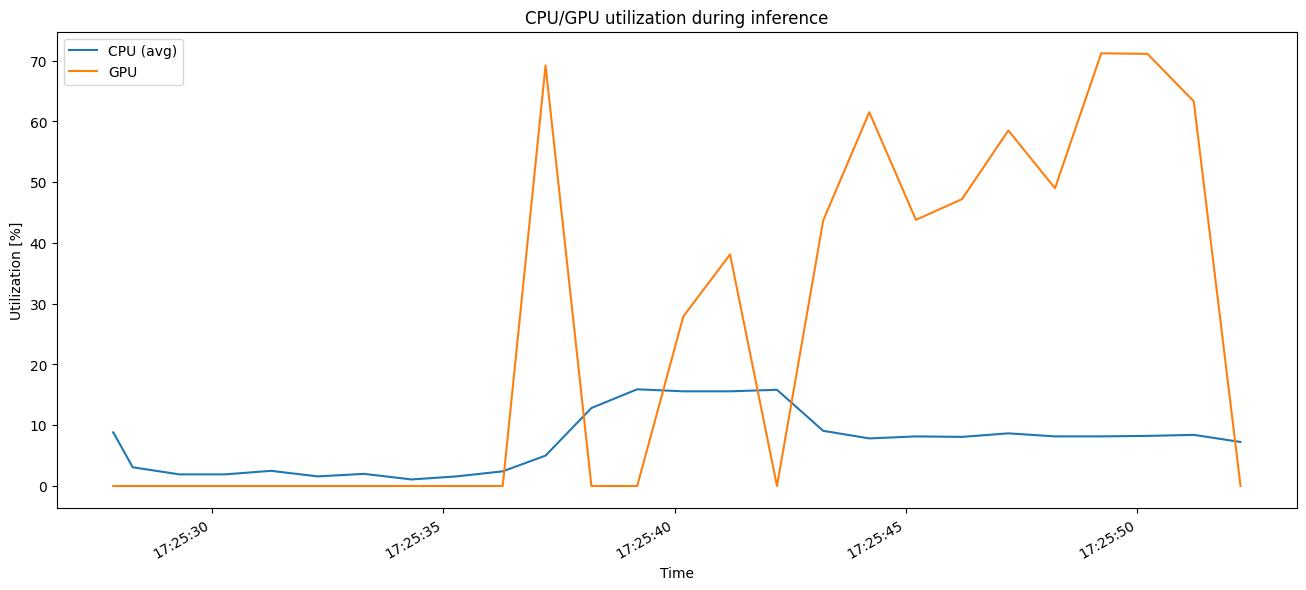

In [13]:
benchmark_results['CPU (avg)'] = benchmark_results[[f'CPU{i+1}' for i in range(12)]].mean(axis=1)

ax = benchmark_results.plot(y=["CPU (avg)", "GPU"], figsize=(16, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.title('CPU/GPU utilization during inference')
plt.xlabel('Time')
plt.ylabel('Utilization [%]')